# Deep Learning y Sistemas Inteligentes - Laboratorio 8
## Predicción de Meses de Ventas
- - -
### Integrantes:
- Diego Alberto Leiva 21752
- José Pablo Orellana 21970
- María Marta Ramírez 21342
- - -

Se le proporcionan 5 años de datos de ventas de artículos de una cadena de tiendas y se le pide que prediga 3 meses de ventas para 50 artículos diferentes en 10 tiendas diferentes. Descarguen el dataset de Kaggle aquí por favor. 

### Librerías

In [48]:
# Manipulacion de datos
import pandas as pd
import numpy as np

# Librerias para visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

# Librerias para PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Librerias para preprocesamiento
from sklearn.preprocessing import StandardScaler

# libreiras para pipeline
from sklearn.pipeline import make_pipeline

# Modelo
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

### Cargar el Dataset

In [3]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

### Visualizar estructura e información general del dataset

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      45000 non-null  int64 
 1   date    45000 non-null  object
 2   store   45000 non-null  int64 
 3   item    45000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.4+ MB


In [6]:
print(f"El dataset contiente: {train_df.shape[0]} observaciones y {train_df.shape[1]} variables")
print(f"El dataset contiente: {test_df.shape[0]} observaciones y {test_df.shape[1]} variables")

El dataset contiente: 913000 observaciones y 4 variables
El dataset contiente: 45000 observaciones y 4 variables


In [7]:
train_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [8]:
test_df.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


#### Variables identificadas
- **id:** Identificador unico 
- **date:** Fecha de la venta
- **store:** Tienda que realizó la venta
- **item:** Objeto vendido
- **sales:** Ventas de ciertos items

### Procesamiento y Limpieza de Datos
#### Verificación y manejo de valores nulos o faltantes
##### Visualizar la data faltante

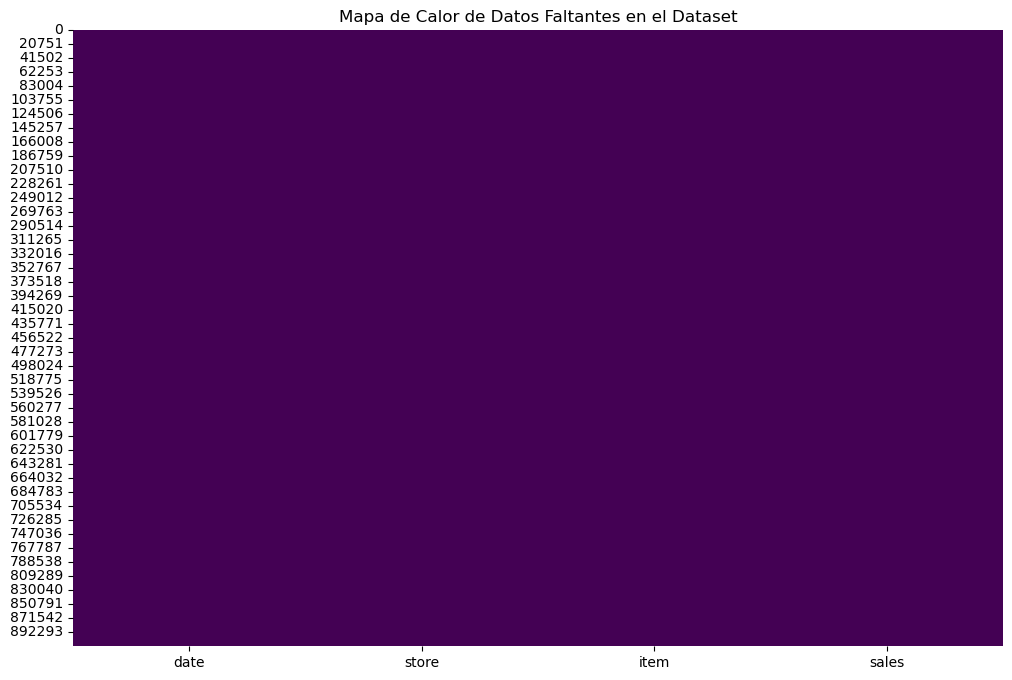

In [9]:
# Crear un mapa de calor para visualizar los datos faltante
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title('Mapa de Calor de Datos Faltantes en el Dataset')
plt.show()

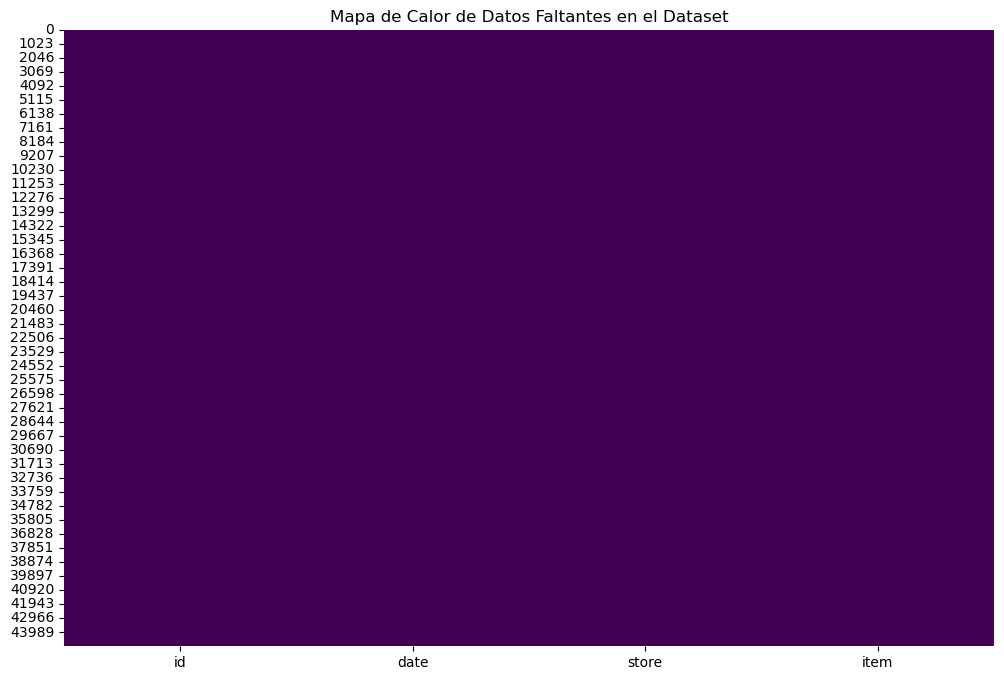

In [10]:
# Crear un mapa de calor para visualizar los datos faltante
plt.figure(figsize=(12, 8))
sns.heatmap(test_df.isnull(), cbar=False, cmap='viridis')
plt.title('Mapa de Calor de Datos Faltantes en el Dataset')
plt.show()

##### Porcentaje de valores nulos

In [11]:
# Calcular el porcentaje de valores nulos para cada tipo
null_percentage_numeric = train_df.isnull().mean() * 100
print(f"Porcentaje de data faltante en variables numericas:")
print(null_percentage_numeric.sort_values(ascending=False))

Porcentaje de data faltante en variables numericas:
date     0.0
store    0.0
item     0.0
sales    0.0
dtype: float64


In [12]:
# Calcular el porcentaje de valores nulos para cada tipo
null_percentage_numeric = test_df.isnull().mean() * 100
print(f"Porcentaje de data faltante en variables numericas:")
print(null_percentage_numeric.sort_values(ascending=False))

Porcentaje de data faltante en variables numericas:
id       0.0
date     0.0
store    0.0
item     0.0
dtype: float64


Como se puede observar en lo anterior mostrado. En el dataset no se poseen valores nulos por lo que no se deberá proceder con la eliminación o sustitución de valores en alguna de las variables presentes.

#### Conversión de fechas
Para este dataset tenemos fechas por lo que se procederá a darle un formato específico a estas variables.

In [13]:
# Convertir la columna 'date' a formato datetime
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

# Crear nuevas características basadas en la fecha
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['day_of_week'] = train_df['date'].dt.dayofweek

test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['day_of_week'] = test_df['date'].dt.dayofweek


In [14]:
train_df.head()

,date,store,item,sales,year,month,day,day_of_week
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5


In [15]:
test_df.head()

,id,date,store,item,year,month,day,day_of_week
0,0,2018-01-01,1,1,2018,1,1,0
1,1,2018-01-02,1,1,2018,1,2,1
2,2,2018-01-03,1,1,2018,1,3,2
3,3,2018-01-04,1,1,2018,1,4,3
4,4,2018-01-05,1,1,2018,1,5,4


Es probable que se necesite convertir la columna date a un formato de fecha y extraer características adicionales como el mes, el día o el día de la semana para que el modelo pueda capturar patrones temporales.

#### Escalado de datos

In [16]:
# Normalizar la columna 'sales'
scaler = MinMaxScaler()
train_df['sales_scaled'] = scaler.fit_transform(train_df[['sales']])

In [17]:
train_df.head()

,date,store,item,sales,year,month,day,day_of_week,sales_scaled
0,2013-01-01,1,1,13,2013,1,1,1,0.056277
1,2013-01-02,1,1,11,2013,1,2,2,0.047619
2,2013-01-03,1,1,14,2013,1,3,3,0.060606
3,2013-01-04,1,1,13,2013,1,4,4,0.056277
4,2013-01-05,1,1,10,2013,1,5,5,0.043290


### División de series temporales

In [18]:
# Ordenar los datos por fecha
train_df = train_df.sort_values('date')

# Definir las fechas para el corte de validación y prueba (asumimos que la fecha más reciente es para el test)
test_size = 3 * 30  # Aproximadamente 3 meses
val_size = 3 * 30   # Aproximadamente 3 meses

# Dividir en conjuntos de entrenamiento, validación y prueba
train_data = train_df.iloc[:-val_size-test_size]
val_data = train_df.iloc[-val_size-test_size:-test_size]
test_data = train_df.iloc[-test_size:]

print(f'Tamaño del conjunto de entrenamiento: {len(train_data)}')
print(f'Tamaño del conjunto de validación: {len(val_data)}')
print(f'Tamaño del conjunto de prueba: {len(test_data)}')


Tamaño del conjunto de entrenamiento: 912820
Tamaño del conjunto de validación: 90
Tamaño del conjunto de prueba: 90


### Generación de secuencias

In [19]:
def create_sequences(data, target_col, window_size=30):
    sequences = []
    targets = []
    
    for i in range(len(data) - window_size):
        seq = data.iloc[i:i+window_size][target_col].values
        target = data.iloc[i+window_size][target_col]
        sequences.append(seq)
        targets.append(target)
    
    return np.array(sequences), np.array(targets)

# Crear secuencias para entrenamiento y validación
window_size = 30  # Una ventana de 30 días de datos históricos
train_sequences, train_targets = create_sequences(train_data, 'sales_scaled', window_size)
val_sequences, val_targets = create_sequences(val_data, 'sales_scaled', window_size)
test_sequences, test_targets = create_sequences(test_data, 'sales_scaled', window_size)

print(f'Tamaño de las secuencias de entrenamiento: {train_sequences.shape}')
print(f'Tamaño de las secuencias de validación: {val_sequences.shape}')
print(f'Tamaño de las secuencias de prueba: {test_sequences.shape}')


Tamaño de las secuencias de entrenamiento: (912790, 30)
Tamaño de las secuencias de validación: (60, 30)
Tamaño de las secuencias de prueba: (60, 30)


### LSTM (Long Short-Term Memory)

In [24]:
# Definir el modelo
def build_lstm_model(input_shape):
    model = Sequential()

    # Capa LSTM 1
    model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())  # Normalización por batches
    model.add(Dropout(0.2))          # Dropout del 20% para evitar overfitting

    # Capa LSTM 2
    model.add(LSTM(units=32, return_sequences=False))
    model.add(BatchNormalization())  # Normalización por batches
    model.add(Dropout(0.2))          # Dropout del 20% para evitar overfitting

    # Capa Densa intermedia
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))          # Otro Dropout del 20%

    # Capa Densa de salida para predicciones
    model.add(Dense(1))  # Salida de una sola unidad, ya que estamos prediciendo las ventas

    # Compilar el modelo
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

# Definir la forma de entrada basada en los datos de las secuencias
input_shape = (train_sequences.shape[1], 1)  # Ventana de 30 días y una variable (sales_scaled)
model = build_lstm_model(input_shape)

# Resumen del modelo
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,785 (120.25 KB)

 Trainable params: 30,593 (119.50 KB)

 Non-trainable params: 192 (768.00 B)

#### Entrenamiento 

In [25]:
# Definir el callback para early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',      # Monitorea la pérdida en el conjunto de validación
    patience=5,              # Detiene el entrenamiento si no hay mejora en 5 épocas
    restore_best_weights=True # Restaura los mejores pesos del modelo
)

# Entrenar el modelo
history = model.fit(
    train_sequences,          # Datos de entrada (secuencias de entrenamiento)
    train_targets,            # Objetivos (ventas escaladas para el entrenamiento)
    validation_data=(val_sequences, val_targets),  # Conjunto de validación
    epochs=50,                # Número de épocas
    batch_size=128,            # Tamaño del batch
    callbacks=[early_stopping], # Callback de early stopping
    verbose=1                 # Mostrar el progreso del entrenamiento
)

Epoch 1/50
7132/7132 ━━━━━━━━━━━━━━━━━━━━ 333s 46ms/step - loss: 0.0348 - val_loss: 0.0099
Epoch 2/50
7132/7132 ━━━━━━━━━━━━━━━━━━━━ 330s 46ms/step - loss: 0.0131 - val_loss: 0.0265
Epoch 3/50
7132/7132 ━━━━━━━━━━━━━━━━━━━━ 331s 46ms/step - loss: 0.0131 - val_loss: 0.0167
Epoch 4/50
7132/7132 ━━━━━━━━━━━━━━━━━━━━ 321s 45ms/step - loss: 0.0130 - val_loss: 0.0096
Epoch 5/50
7132/7132 ━━━━━━━━━━━━━━━━━━━━ 330s 46ms/step - loss: 0.0129 - val_loss: 0.0097
Epoch 6/50
7132/7132 ━━━━━━━━━━━━━━━━━━━━ 332s 47ms/step - loss: 0.0130 - val_loss: 0.0098
Epoch 7/50
7132/7132 ━━━━━━━━━━━━━━━━━━━━ 325s 46ms/step - loss: 0.0130 - val_loss: 0.0092
Epoch 8/50
7132/7132 ━━━━━━━━━━━━━━━━━━━━ 331s 46ms/step - loss: 0.0130 - val_loss: 0.0094
Epoch 9/50
7132/7132 ━━━━━━━━━━━━━━━━━━━━ 330s 46ms/step - loss: 0.0129 - val_loss: 0.0092
Epoch 10/50
7132/7132 ━━━━━━━━━━━━━━━━━━━━ 331s 46ms/step - loss: 0.0129 - val_loss: 0.0093
Epoch 11/50
7132/7132 ━━━━━━━━━━━━━━━━━━━━ 325s 46ms/step - loss: 0.0130 - val_loss: 0.00

#### Evaluar el rendimiento

In [26]:
# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(test_sequences, test_targets)
print(f'Pérdida en el conjunto de prueba: {test_loss}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0153
Pérdida en el conjunto de prueba: 0.014417080208659172


In [27]:
# Hacer predicciones en el conjunto de prueba
predictions = model.predict(test_sequences)

# Mostrar algunas predicciones junto con los valores reales
for i in range(5):  # Mostrar las primeras 5 predicciones
    print(f'Predicción: {predictions[i]}, Valor real: {test_targets[i]}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 491ms/step
Predicción: [0.23220628], Valor real: 0.2683982683982684
Predicción: [0.23394635], Valor real: 0.3203463203463203
Predicción: [0.23665534], Valor real: 0.3203463203463203
Predicción: [0.23884998], Valor real: 0.3116883116883117
Predicción: [0.24163818], Valor real: 0.30735930735930733


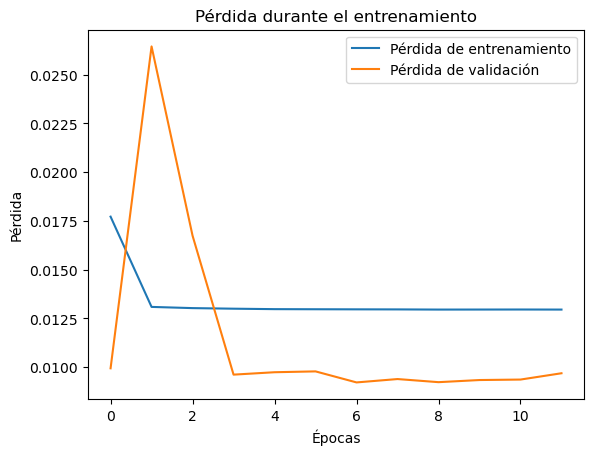

In [28]:
# Graficar la pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

#### Forecasting

In [36]:
forecast_results = []

# Recorremos las secuencias de prueba directamente
for i in range(len(test_sequences)):  # Iterar sobre todas las secuencias de prueba
    
    # Extraer la tienda y el artículo correspondientes
    store_id = test_data['store'].iloc[i]
    item_id = test_data['item'].iloc[i]
    
    # Extraer la secuencia correspondiente
    item_sequence = test_sequences[i:i+1]  # Obtenemos una sola secuencia
    
    # Realizar la predicción
    prediction = model.predict(item_sequence)
    
    # Almacenar las predicciones
    forecast_results.append({
        'store': store_id,
        'item': item_id,
        'predictions': prediction
    })

# Mostrar las primeras 5 predicciones
for i in range(5):
    print(f"Tienda: {forecast_results[i]['store']}, Artículo: {forecast_results[i]['item']}, Predicciones: {forecast_results[i]['predictions'][:5]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

#### Visualización de resultados

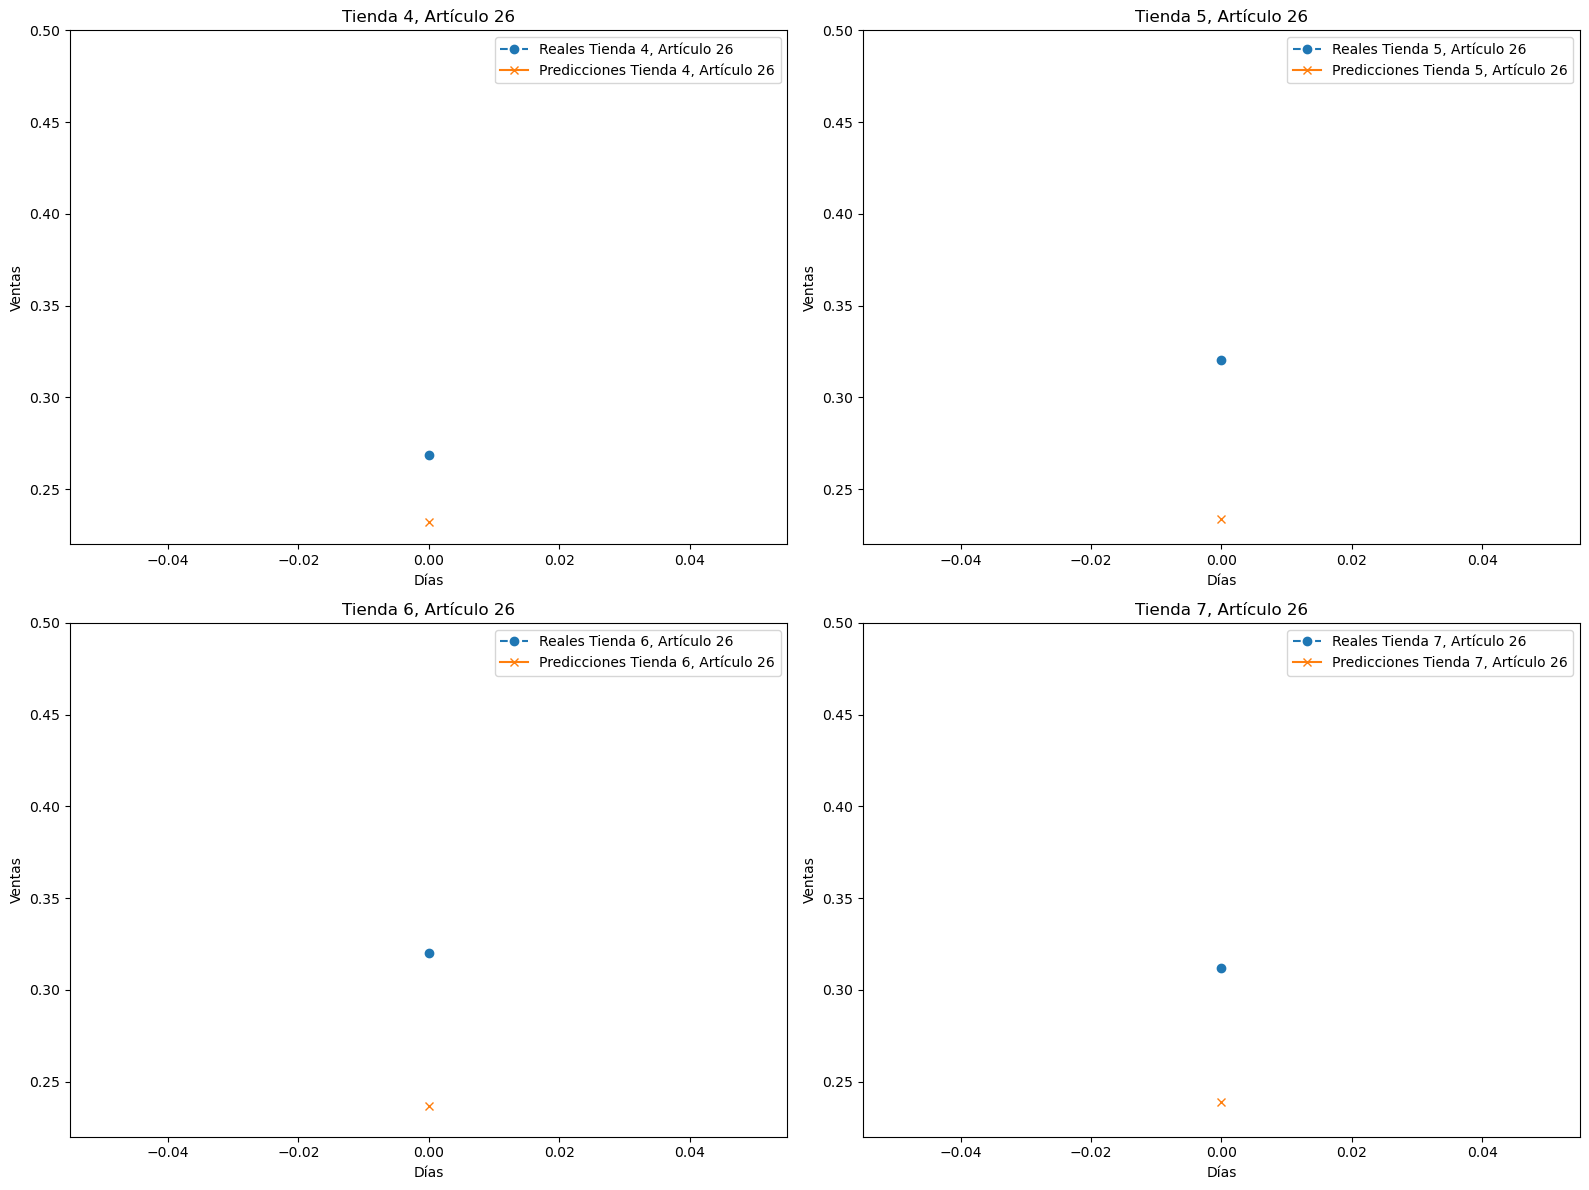

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  
axes = axes.flatten()  

for i in range(4):  # Visualizar 4 tiendas
    store_id = forecast_results[i]['store']
    item_id = forecast_results[i]['item']
    predictions = forecast_results[i]['predictions']
    
    real_sales = test_targets[i]  # Extraemos el valor escalar correspondiente directamente

    # Graficar ventas reales vs predicciones en el subplot correspondiente
    axes[i].plot([real_sales], label=f'Reales Tienda {store_id}, Artículo {item_id}', linestyle='--', marker='o')
    axes[i].plot(predictions.flatten(), label=f'Predicciones Tienda {store_id}, Artículo {item_id}', marker='x')

    axes[i].set_title(f'Tienda {store_id}, Artículo {item_id}')
    axes[i].set_xlabel('Días')
    axes[i].set_ylabel('Ventas')

    axes[i].set_ylim(0.22, 0.5)  # Rango ajustado del eje Y para una visualización más realista

    axes[i].legend()

plt.tight_layout()
plt.show()
